In [1]:
import time
startTime = time.time()
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pixstem.api as ps
import multiprocessing
import hyperspy.api as hs
import ctypes
import csv

file = hs.load("input1.blo")

In [2]:
def distance(x1, y1, x2, y2):
    return np.sqrt(pow(x1 - x2, 2) + pow(y1 - y2, 2))

def pos_dist(x1, y1, x2, y2):
    if (x2 > x1 and y2 > y1):
        return np.sqrt(pow(x1 - x2, 2) + pow(y1 - y2, 2))
    else:
        return -1.0
def findCenter(im, peak):
    center = (0,0)
    maximum = 0
    for (a,b) in np.ndenumerate(peak):
        for (y, x) in b:
            if (5 < int(x) < len(im) - 5 and 5 < int(y) < len(im) - 5 and im[int(y)][int(x)] > maximum):
                maximum = im[int(y)][int(x)]
                center = (x, y)
    return center
def multiprocessing_func(i, j):
    s = ps.PixelatedSTEM(hs.signals.Signal2D(file.inav[i, j]))
    imarray = np.array(s)
    s = s.rotate_diffraction(0,show_progressbar=False)
    ############################################################################################################################
    st = s.template_match_disk(disk_r=5, lazy_result=False, show_progressbar=False)
    peak_array = st.find_peaks(lazy_result=False, show_progressbar=False)
    peak_array_com = s.peak_position_refinement_com(peak_array, lazy_result=False, show_progressbar=False)
    s_rem = s.subtract_diffraction_background(lazy_result=False, show_progressbar=False)
    peak_array_rem_com = s_rem.peak_position_refinement_com(peak_array, lazy_result=False, show_progressbar=False)
    ############################################################################################################################
    center = findCenter(imarray, peak_array_rem_com)

    # finds the specific spot and adding that distance to the array
    posDistance = 0
        
    """for (x,y) in np.ndenumerate(peak_array_rem_com):
        prev = (0, 0)
        for (a, b) in y:
            if abs(center[0] - b) < 1E-5 and abs(center[1] - a) < 1E-5:
                posDistance = distance(center[0], center[1], prev[1], prev[0])
                #posDistance = imarray[int(prev[1])][int(0)]
                break
            prev = (a, b)"""
    
    
    point = (0, 0)
    maxX = 0
    for (a,b) in np.ndenumerate(peak_array_rem_com):
        for (y,x) in b:
            if center[1] < y < 140 and center[0] < x < 140 and maxX < x:
                point = (x,y)
    posDistance = distance(center[0], center[1], point[0], point[1])
    distances[j][i] = round(posDistance, 2)

In [3]:
ROW = 200
COL = 200

shared_array_base = multiprocessing.Array(ctypes.c_double, ROW*COL)
distances = np.ctypeslib.as_array(shared_array_base.get_obj())
distances = distances.reshape(COL, ROW)

for i in range(ROW):
    print(i)
    processes = []
    for j in range(COL):
        p = multiprocessing.Process(target=multiprocessing_func, args=(i, j,))
        processes.append(p)
        p.start()

    for process in processes:
        process.join()    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [4]:
file = open("outputDistances.csv", "w")
writer = csv.writer(file)
for i in distances:
    writer.writerow(i)
file.close()

[[38.45 38.43 38.39 ... 38.6  38.53 38.68]
 [38.44 38.45 38.48 ... 38.6  38.64 38.66]
 [38.37 38.37 38.41 ... 38.64 38.42 38.66]
 ...
 [38.6  38.64 38.61 ... 38.73 38.77 38.75]
 [38.68 38.62 38.62 ... 38.74 38.75 38.59]
 [38.66 38.63 38.61 ... 38.82 38.73 38.67]]


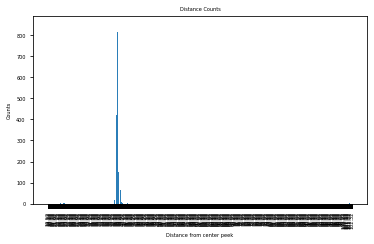

Total time taken: 825.870171546936


In [26]:
INTERVAL = 0.01 # this 0.01 is the distance between each x-axis label. So for example it goes 1.0, 1.01, 1.02 1.03...
print(distances)

distances = distances.flatten()
x_pos = np.arange(np.min(distances), np.max(distances), INTERVAL) # this 0.01 is the distance between each x-axis label. So for example it goes 1.0, 1.01, 1.02 1.03...
x_pos = [round(num, 2) for num in x_pos]
y_pos = np.arange(len(x_pos))
################################################################################################################################
from collections import Counter
counter = Counter(distances)
counts = []
for i in x_pos:
        counts.append(counter[i]) if i in counter.keys() else counts.append(0)
################################################################################################################################
plt.bar(y_pos, counts, align='center', alpha=0.95) # creates the bar plot
plt.xticks(y_pos, x_pos, fontsize = 5)
plt.xlabel('Distance from center peek', fontsize = 5)
plt.ylabel('Counts', fontsize = 5)
plt.title('Distance Counts', fontsize = 5)

ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=90)
ax.tick_params(axis='x', which='major', labelsize=5)
ax.tick_params(axis='y', which='major', labelsize=5)

[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % 30 != 0] 
# The '2' is the every nth number of labels its shows on the x-axis. So rn is shows every 2nd label. 

plt.gcf().subplots_adjust(bottom = 0.23)
plt.rcParams["figure.dpi"] = 500
plt.savefig("300x500BarChart.png")
plt.show()
print("Total time taken:", time.time() - startTime)

#### 